## HotDog or No Hotdog!
Training on Cloud ML

In [2]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
import google.datalab.bigquery as bq
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

In [18]:
bucket = 'gs://' + datalab_project_id() + '-lab'
preprocess_dir = bucket + '/hotdogpreprocessedcloud'
model_dir = bucket + '/hotdogmodelcloud'
staging_dir = bucket + '/staging'

In [12]:
!gsutil mb $bucket



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Creating gs://jcham-1469824226729-lab/...
ServiceException: 409 Bucket jcham-1469824226729-lab already exists.


## Data Wrangling and Manipulation
1.  Download the data locally
2.  Change URL to cloud storage

In [7]:
all_images = pd.read_csv('200-hotdog-train.csv')

In [8]:
#used to change location of URL to local storage for quick experimentation. 
for index, row in all_images.iterrows():
  url = row['original_url']
  new_url = os.path.join('gs://hotdog-images/', os.path.basename(url))
  row['original_url'] = new_url

## Create CSV

In [9]:
all_images.head()

,original_url,label_name
0,gs://hotdog-images/8354515040_4ae1e2d3e5_o.jpg,no_hotdog
1,gs://hotdog-images/14802998889_e54787d523_o.jpg,no_hotdog
2,gs://hotdog-images/5065333466_03e7785a4d_o.jpg,no_hotdog
3,gs://hotdog-images/4149154501_c72424650f_o.jpg,no_hotdog
4,gs://hotdog-images/11108121565_61e1d80d33_o.jpg,no_hotdog


In [14]:
all_images.to_csv('cloud-train-file.csv', header=False, index=False)

In [15]:
!gsutil cp cloud-train-file.csv gs://hotdog-images/

Copying file://cloud-train-file.csv [Content-Type=text/csv]...
/ [1 files][ 10.9 KiB/ 10.9 KiB]                                                
Operation completed over 1 objects/10.9 KiB.                                     


# Create Training Dataset
http://googledatalab.github.io/pydatalab/google.datalab.ml.html?highlight=csvdataset#google.datalab.ml.CsvDataSet

DataSet based on CSV files and schema.

In [16]:
#Create CsvDataSet file for training.
train_set = CsvDataSet('gs://hotdog-images/cloud-train-file.csv', schema='image_url:STRING, label:STRING')

In [20]:
model.preprocess(train_set, preprocess_dir, cloud={'num_workers':10})
# what is the output of this?? what is in the preprocessed directory?

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:132: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Job "preprocess-image-classification-170724-215446" submitted. Click here to track preprocessing job.

completed


In [21]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.WARNING)

## Training
batch size = 30, max_steps = 800

In [23]:
model.train(preprocess_dir, 30, 800, model_dir) 

INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 5.49167


INFO:tensorflow:global_step/sec: 5.49167


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: gs://jcham-1469824226729-lab/hotdogmodelcloud/model/saved_model.pb


INFO:tensorflow:SavedModel written to: gs://jcham-1469824226729-lab/hotdogmodelcloud/model/saved_model.pb


completed


In [39]:
summary = Summary(model_dir)

TypeError: get_events() takes exactly 2 arguments (1 given)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


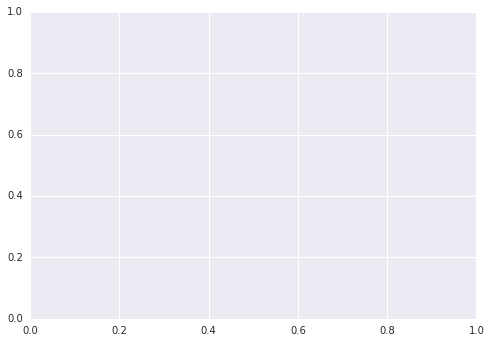

In [25]:
summary.plot('loss')

In [260]:
tb_id = TensorBoard.start(model_dir)

TensorBoard was started successfully with pid 4833. Click here to access it.

# Sanity Check
Flower was NOT part of the training set

Predicting...


no_hotdog(0.68625)

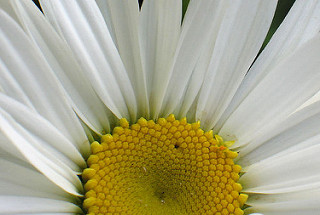

In [26]:
images = ['gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg']
df = model.predict(model_dir, images, show_image=True)

# Time to Batch Predict

In [127]:
!wget https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg

converted 'https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg' (ANSI_X3.4-1968) -> 'https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg' (UTF-8)
--2017-07-24 20:54:27--  https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169004 (165K) [image/jpeg]
Saving to: 'hot-dog-grilling-24681095.jpg'

hot-dog-grilling-24 100%[=====================>] 165.04K  --.-KB/s   in 0.03s  

2017-07-24 20:54:27 (4.88 MB/s) - 'hot-dog-grilling-24681095.jpg' saved [169004/169004]



In [40]:
images = ['/content/hotdog/notdogfull.jpg','/content/hotdog/landscape-1464119445-buffalo-chicken-taquitos-004.jpg', '/content/hotdog/2016-09-20_1101.jpg', '/content/hotdog/cf468fb8e2efb4fbbc4f2895f71f1e32.jpg', '/content/hotdog/Cartoon-hot-dog-clipart-kid-2.jpeg']
#images = ['/content/hotdog/hot-dog-grilling-24681095.jpg']

Predicting...


hotdog(0.99114)

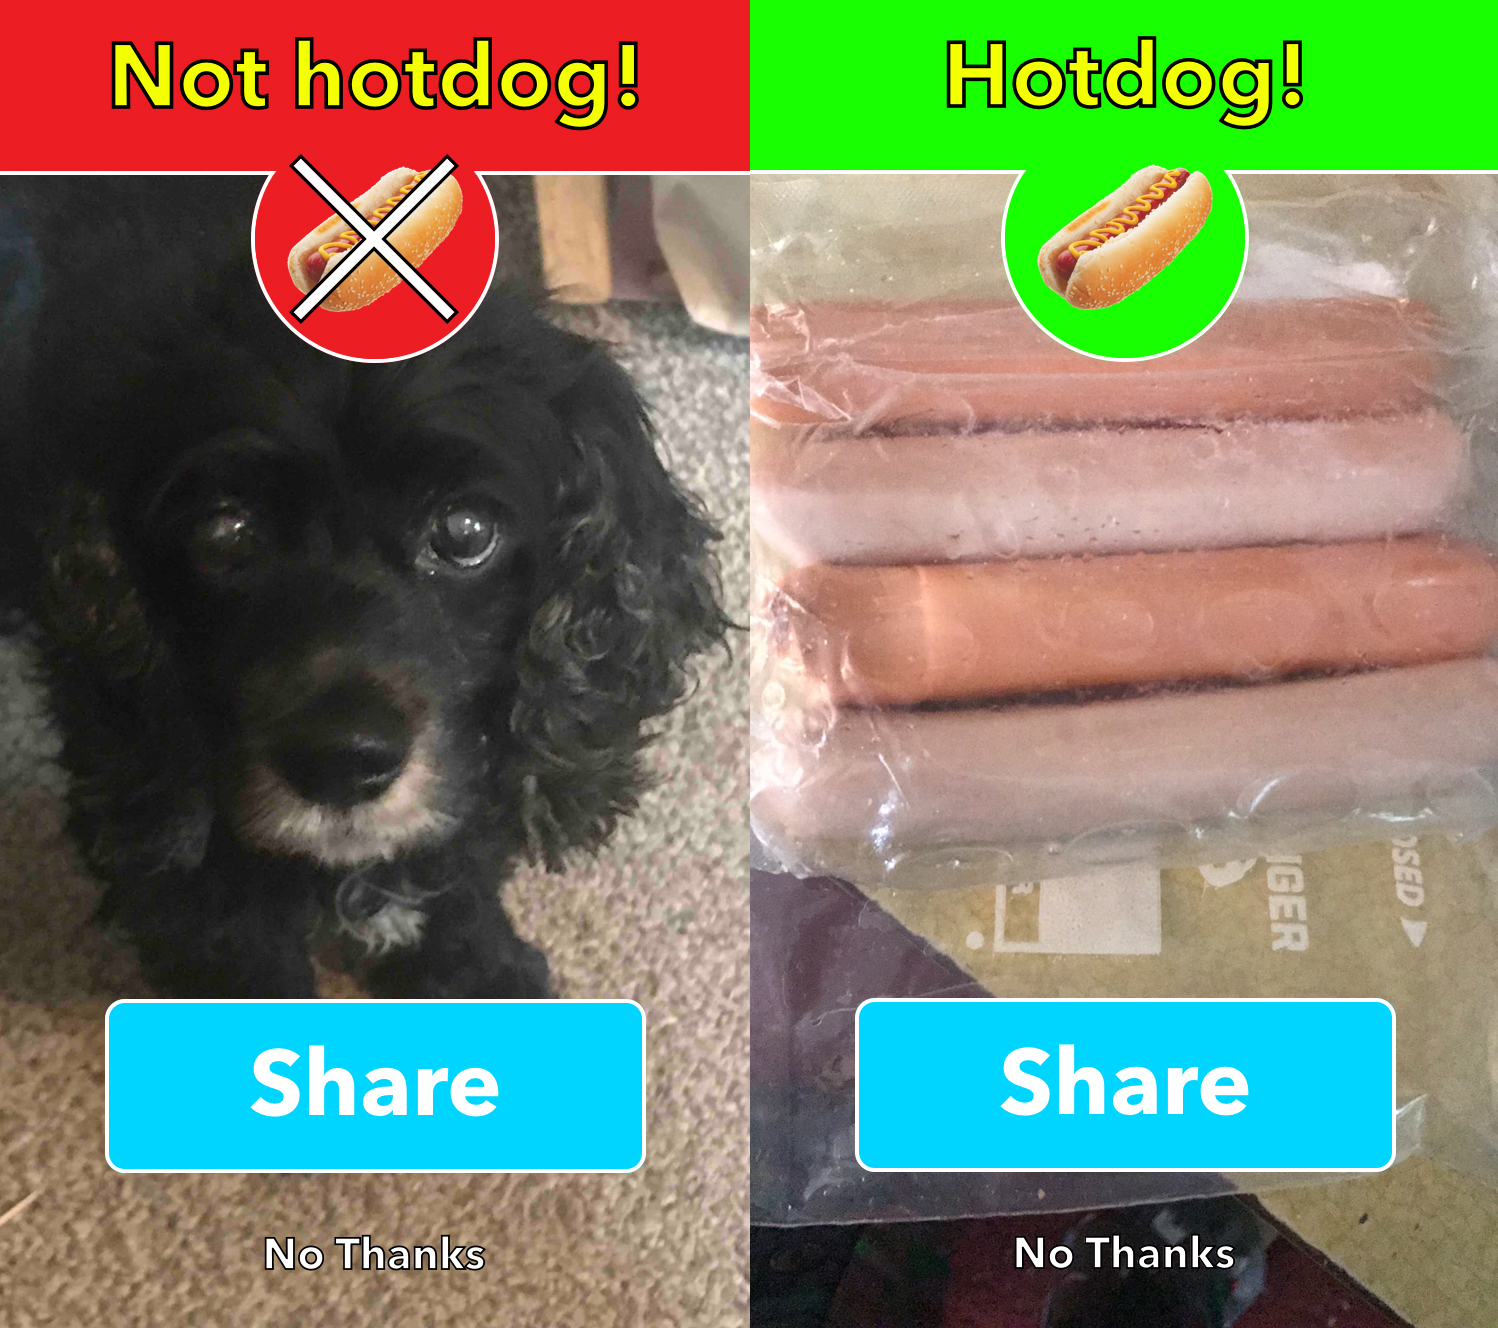

no_hotdog(0.99996)

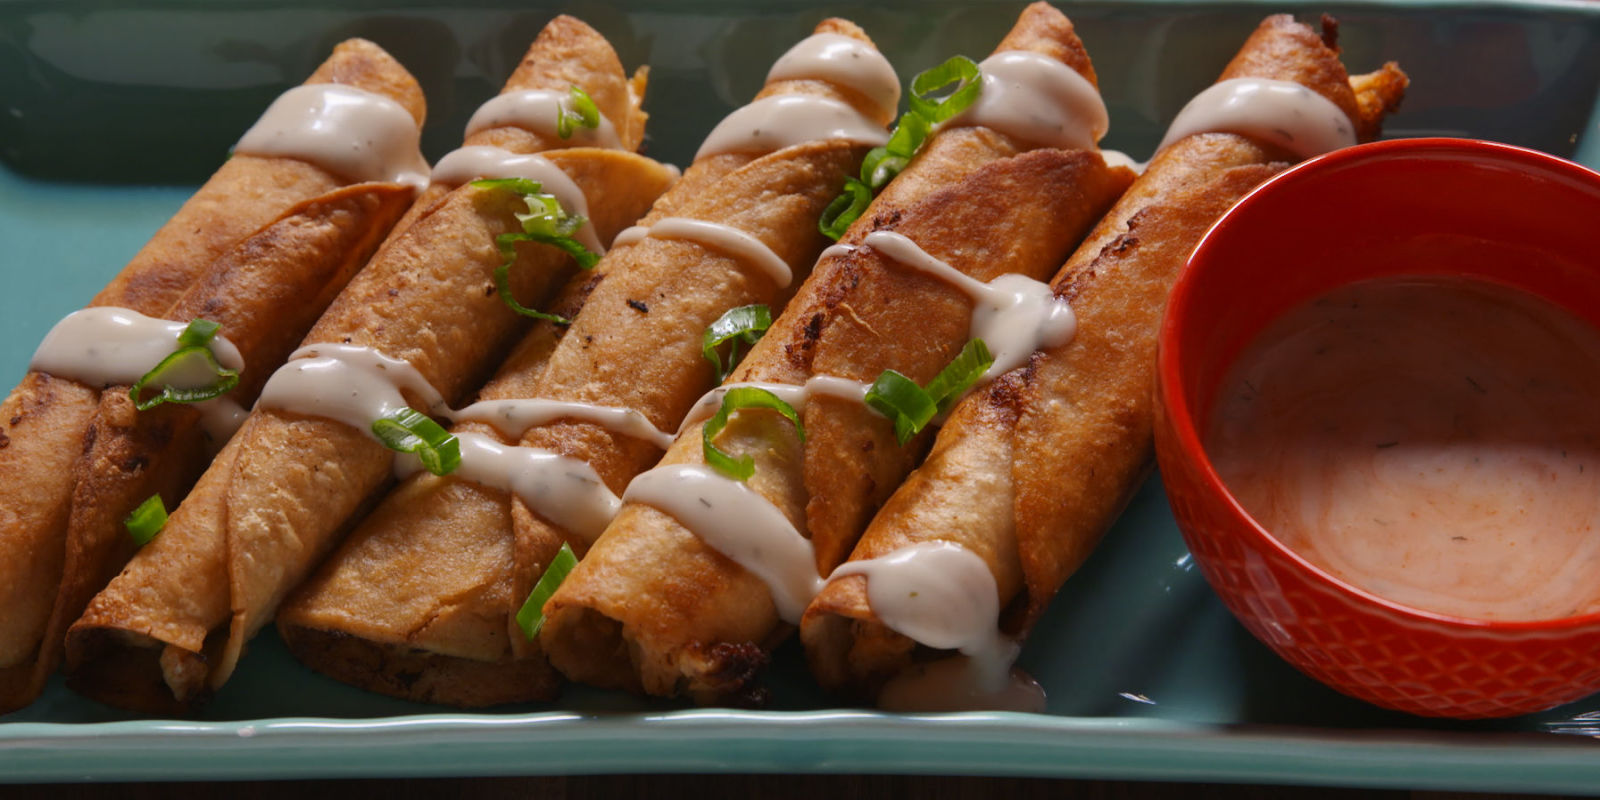

hotdog(0.93262)

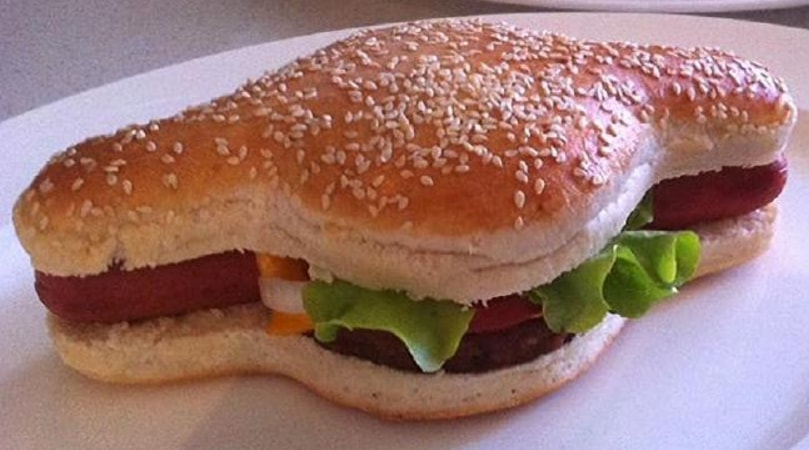

hotdog(0.98551)

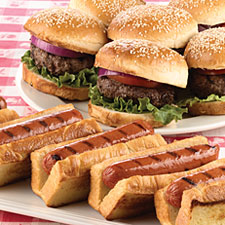

hotdog(0.93246)

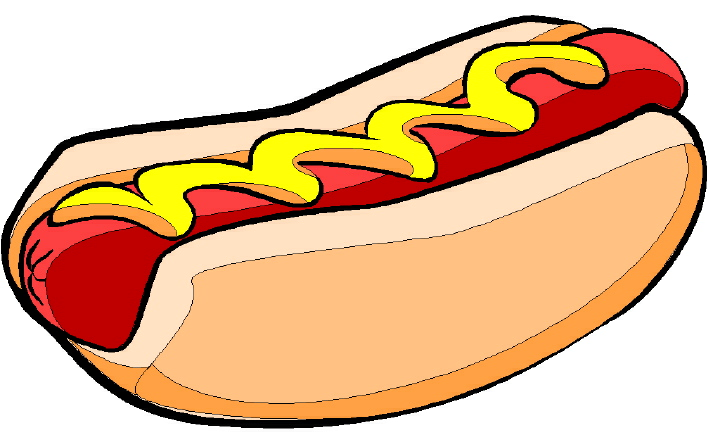

In [41]:
df = model.predict(model_dir, images, show_image=True)